In [1]:
# Add the directory above the current notebook's directory to the system path
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
from datasets import load_flower_dataset
import matplotlib.pyplot as plt
import numpy as np

### PLot functions

In [2]:
def plot_scatter(X:np.ndarray, Y:np.ndarray):
    '''
    Show the scatter plot of flower dataset
    
    Parameters
    ----------
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data; dtype: float64
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1; dtype: uint8 
    '''
    scatter=plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
    plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    # plt.show()
    

def plot_decision_boundary(predict, parameters, X, Y):
    """
    Plot the decision boundary for logistic regression
    
    Parameters
    ----------
    predict : function
        predicted output; dtype=int8 
    parameters : dict
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data; dtype: float64
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1; dtype: uint8
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    # Y = None argument is dumpy as not used when print_accuracy=False
    Z = predict(np.c_[xx.ravel(), yy.ravel()].T, None, parameters, print_accuracy=False)
    
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plot_scatter(X,Y)

### Import data

(2, 500) (1, 500)


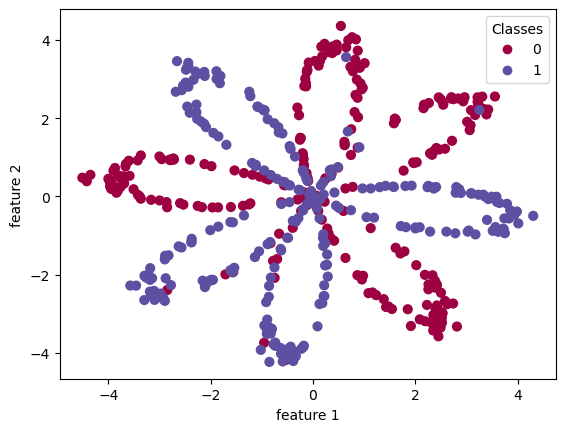

In [3]:
X,Y = load_flower_dataset( petals=4, noise=0.2, angle=30)
print(X.shape, Y.shape)
plot_scatter(X,Y)

### L Layer Neural Network Model

In [4]:
def layer_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z = np.matmul(W,A_prev) + b
        A = 1/(1+np.exp(-Z))
    elif activation == "relu":
        Z = np.matmul(W,A_prev) + b
        A = np.maximum(0,Z)
    elif activation == "tanh":
        Z = np.matmul(W,A_prev) + b
        A = np.tanh(Z)    
    cache = ((A_prev,W,b), Z)  # linear_cache, activation_cache
    return A, cache


def layer_backward(dA, cache, activation):
    # linear_cache, activation_cache = cache
    (A_prev,W,b), Z = cache
    m = A_prev.shape[1]
    if activation == "relu":
        dZ = np.array(dA, copy=True) # just converting dz to a correct object.
        # When z <= 0, you should set dz to 0 as well. 
        dZ[Z <= 0] = 0
        dW = 1/m*np.matmul(dZ,A_prev.T)
        db = 1/m*np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.matmul(W.T,dZ)
    elif activation == "sigmoid":
        a = 1/(1+np.exp(-Z))
        dZ = dA * a * (1-a)
        dW = 1/m*np.matmul(dZ,A_prev.T)
        db = 1/m*np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.matmul(W.T,dZ)
    elif activation == "tanh":
        a = np.tanh(Z)
        dZ = dA * ( 1- np.square(a) )
        dW = 1/m*np.matmul(dZ,A_prev.T)
        db = 1/m*np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.matmul(W.T,dZ)
    return dA_prev, dW, db

def plot_costs(costs, learning_rate):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()


def predict(X, Y, parameters, activation_L_1="relu", activation_L="sigmoid", print_accuracy=True):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X; dtype=int8
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m),dtype=np.int8)
    
    # Forward propagation
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = layer_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = activation_L_1)
        caches.append(cache)
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = layer_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = activation_L)
    caches.append(cache)
       
    # convert probas to 0/1 predictions
    for i in range(0, AL.shape[1]):
        if AL[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(Y))
    if print_accuracy:
        print(f"Accuracy: {np.sum((p == Y)/m)*100} %")  
    return p


In [5]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_epochs = 3000, activation_L_1="relu", activation_L="sigmoid", print_cost=False):
    grads = {}
    costs = []                         # keep track of cost
    m = X.shape[1]                           # number of examples
    L = len(layers_dims) # number of layers in the network

    # Parameters initialization.
    parameters = {}
    np.random.seed(3)   
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) / np.sqrt(layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
    
    # Loop (gradient descent)
    for i in range(0, num_epochs):
        
        ## Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        caches = []  # tuple(A_prev,W,b) list for each layer
        A = X
        L = len(parameters) // 2                 # number of layers in the neural network
        for l in range(1, L):                    # The for loop starts at 1 because layer 0 is the input
            A_prev = A 
            A, cache = layer_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = activation_L_1)
            caches.append(cache)  # cache = ((A_prev,W,b), Z)
        AL, cache = layer_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = activation_L)
        caches.append(cache)
        
        m = Y.shape[1]
        ## Compute cost from A_L and Y.
        cost = -1/m*np.sum(np.multiply(np.log(AL),Y) + np.multiply(np.log(1-AL),1-Y))
        cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
        
        ## Backward propagation.
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))    # derivative of cost with respect to AL
        # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
        current_cache = caches[L-1]
        dA_prev_temp, dW_temp, db_temp = layer_backward(dAL, current_cache, activation = activation_L)
        grads["dA" + str(L-1)] = dA_prev_temp
        grads["dW" + str(L)] = dW_temp
        grads["db" + str(L)] = db_temp
        # Loop from l=L-2 to l=0
        for l in reversed(range(L-1)):
            # lth layer: (RELU -> LINEAR) gradients.
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = layer_backward(grads["dA" + str(l + 1)], current_cache, activation = activation_L_1)
            grads["dA" + str(l)] = dA_prev_temp
            grads["dW" + str(l+1)] = dW_temp
            grads["db" + str(l+1)] = db_temp
        
        # Update parameters.
        for l in range(L):
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
                
        # Print the cost every 100 iterations
        if i % 100 == 0 or i == num_epochs - 1:
            costs.append(cost)
            if print_cost:
                print(f"Cost in epoch {i+1}: {cost}")
    
    return parameters, costs

### Detailed info, plots demo

Cost in epoch 1: 0.7815243802593791
Cost in epoch 101: 0.6558587800025234
Cost in epoch 201: 0.6311527681437692
Cost in epoch 301: 0.6064862542601696
Cost in epoch 401: 0.5814219406994146
Cost in epoch 501: 0.5560497374386837
Cost in epoch 601: 0.5301108599617409
Cost in epoch 701: 0.5031547871226085
Cost in epoch 801: 0.47610022261934537
Cost in epoch 901: 0.4502582431183231
Cost in epoch 1001: 0.4264536408884888
Cost in epoch 1101: 0.40551656327198865
Cost in epoch 1201: 0.3873454388219951
Cost in epoch 1301: 0.37179297626527386
Cost in epoch 1401: 0.35859818850255354
Cost in epoch 1501: 0.3474224213213091
Cost in epoch 1601: 0.33792034846311425
Cost in epoch 1701: 0.3297534792315358
Cost in epoch 1801: 0.3226843452149244
Cost in epoch 1901: 0.31652855880618425
Cost in epoch 2000: 0.31112741781419984
Accuracy: 91.00000000000003 %


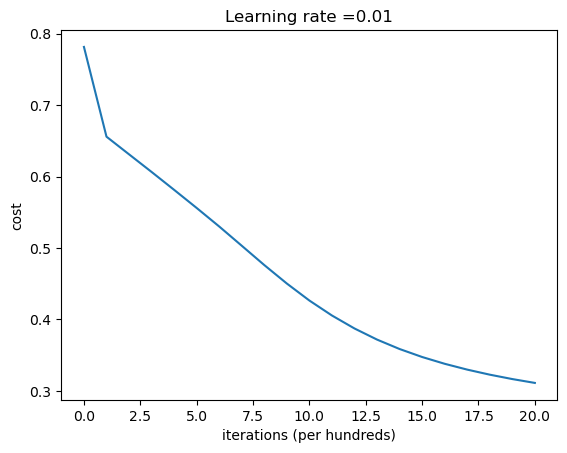

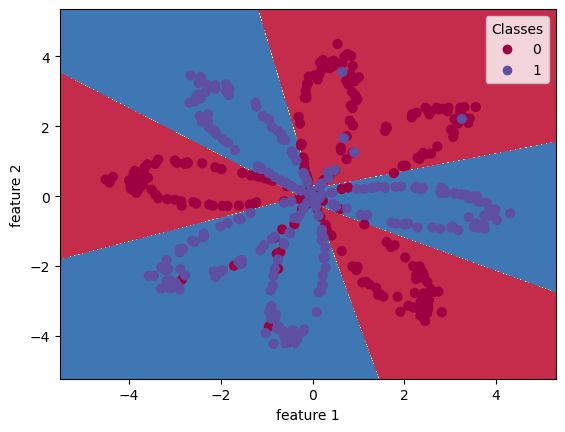

In [6]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[0],12,12, 1]

parameters, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=True)
Y_pred_out=predict(X, Y, parameters,activation_L_1,activation_L)
plot_costs(costs, learning_rate)
plot_decision_boundary(predict, parameters, X, Y)

### Single Neuron Model Run

Accuracy: 47.199999999999996 %


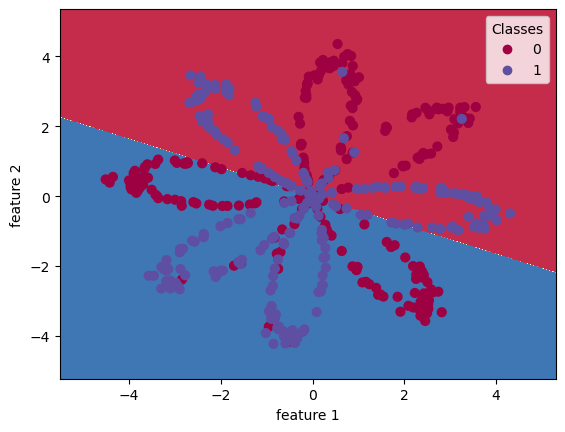

In [7]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[0], 1]

parameters, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
Y_pred_out=predict(X, Y, parameters,activation_L_1,activation_L)
plot_decision_boundary(predict, parameters, X, Y)

### 2 Layers (or 1 hidden layer) Neural Network with 1 neuron in output layer

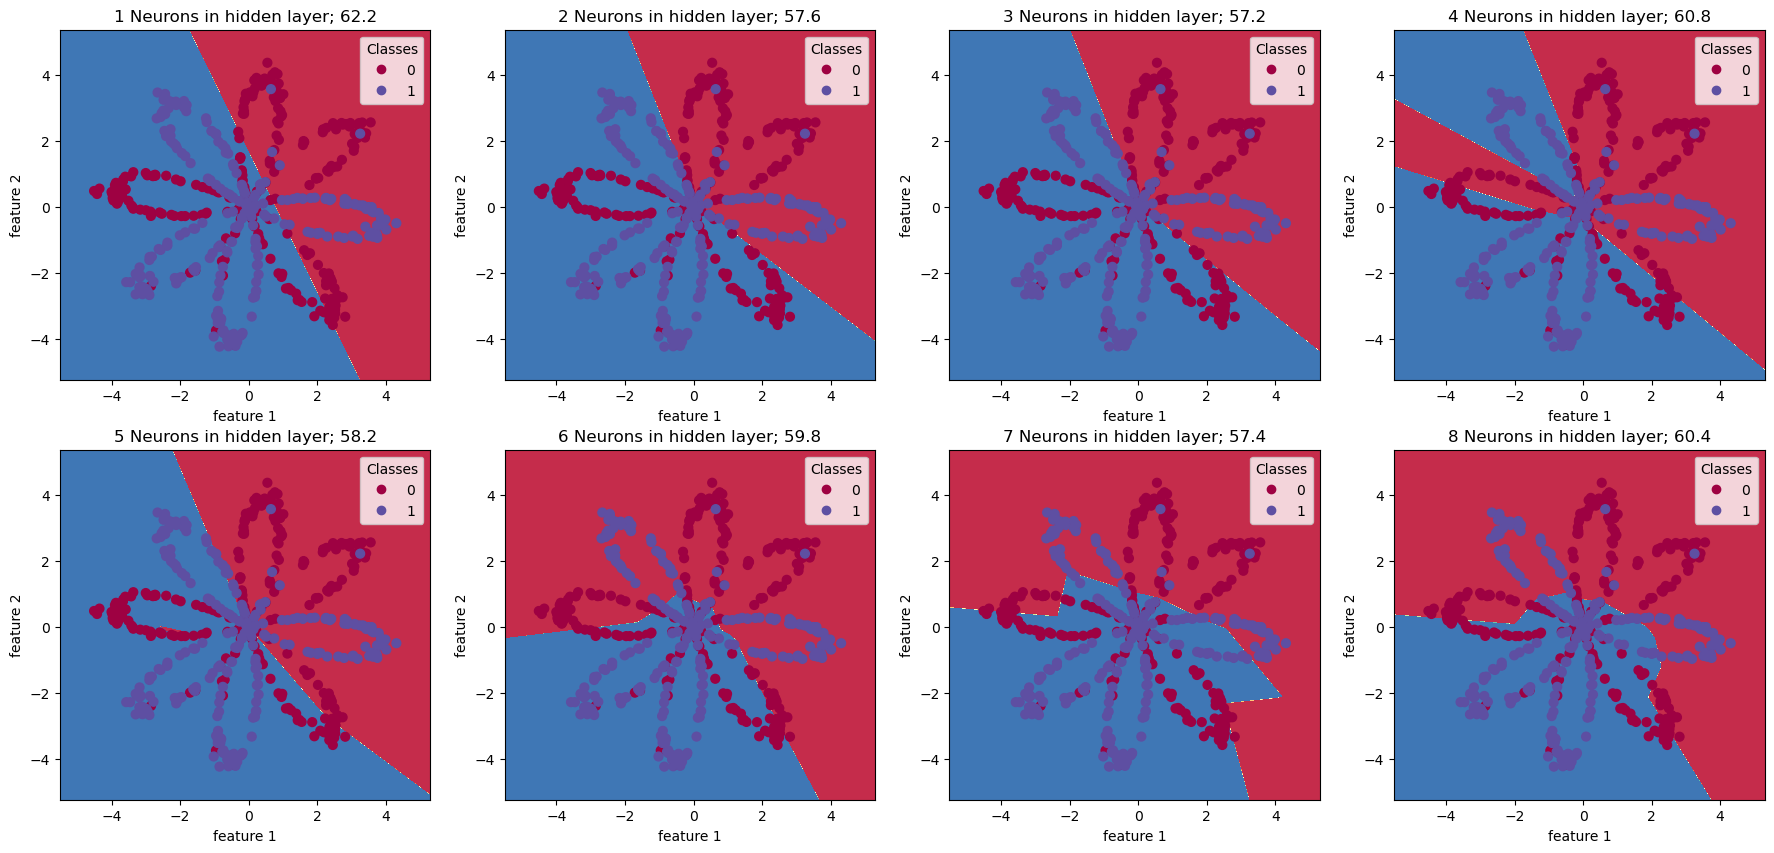

In [8]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[0],1, 1]
plt.rcParams['figure.figsize'] = (22.0, 10.0) # width, height
for i in range(1,9):
        layers_dims=[X.shape[0],i, 1]
        plt.subplot(2, 4, i)
        parameters, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
        Y_pred_out=predict(X, Y, parameters,activation_L_1,activation_L, print_accuracy=False)
        plot_decision_boundary(predict, parameters, X, Y)
        plt.title(f"{i} Neurons in hidden layer; {np.round(np.mean(Y_pred_out == Y)*100, 3)}")


### 3 Layers (or 2 hidden layers) Neural Network with 1 neuron in output layer

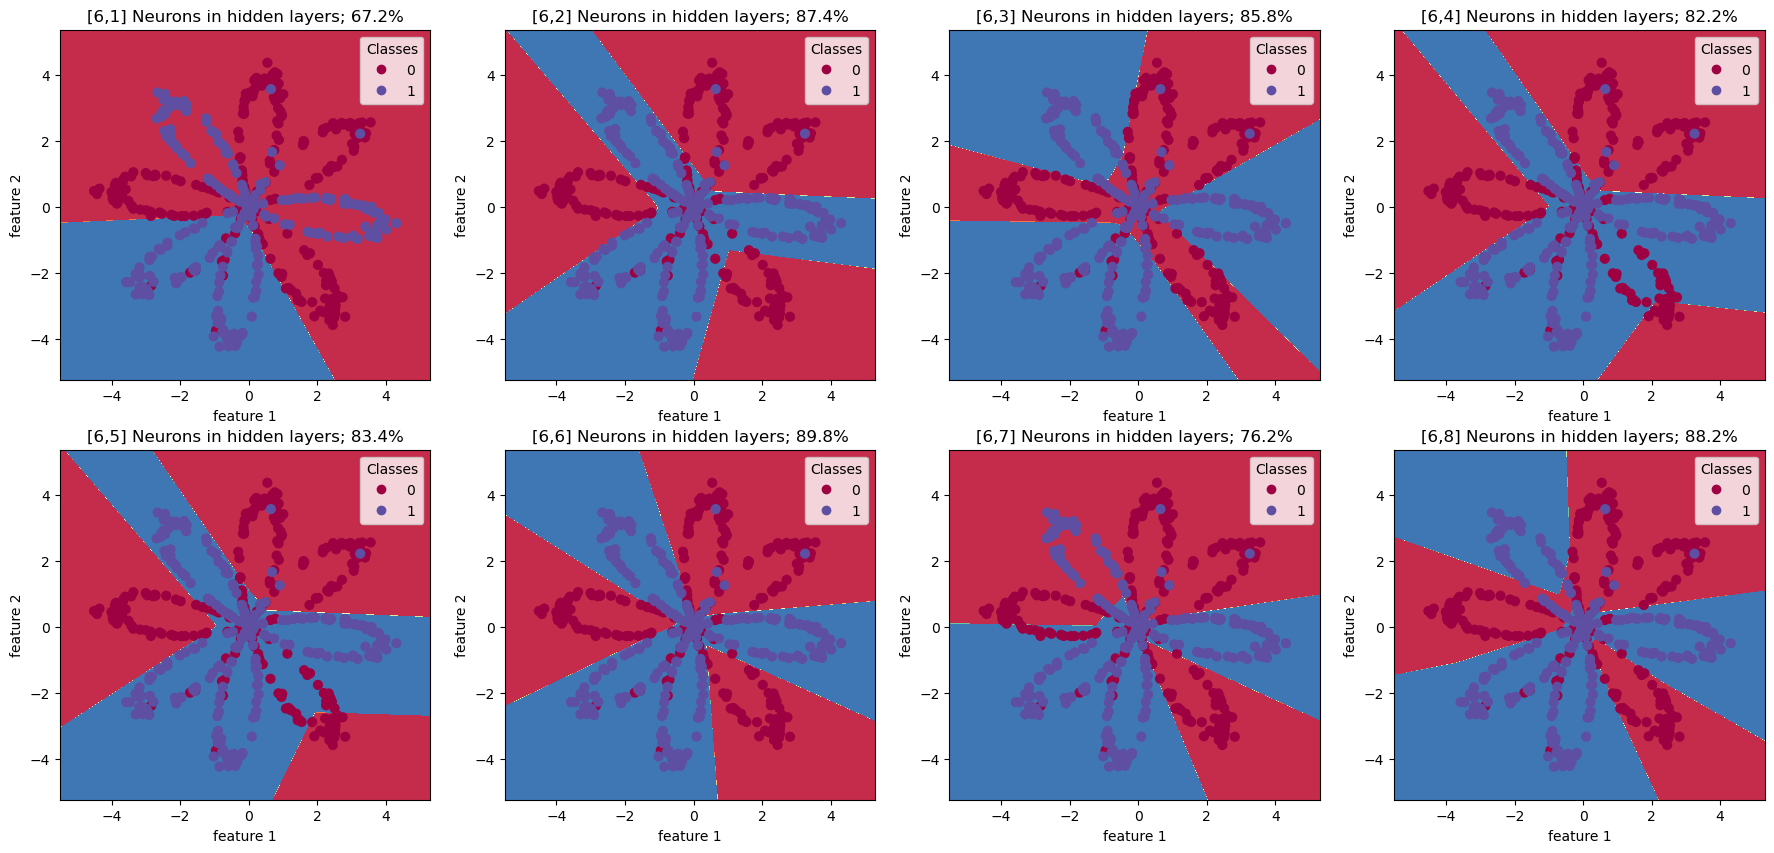

In [9]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[0],6,1, 1]
plt.rcParams['figure.figsize'] = (22.0, 10.0) # width, height
for i in range(1,9):
        layers_dims=[X.shape[0],6,i, 1]
        plt.subplot(2, 4, i)
        parameters, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
        Y_pred_out=predict(X, Y, parameters,activation_L_1,activation_L, print_accuracy=False)
        plot_decision_boundary(predict, parameters, X, Y)
        plt.title(f"[6,{i}] Neurons in hidden layers; {np.round(np.mean(Y_pred_out == Y)*100, 3)}%")

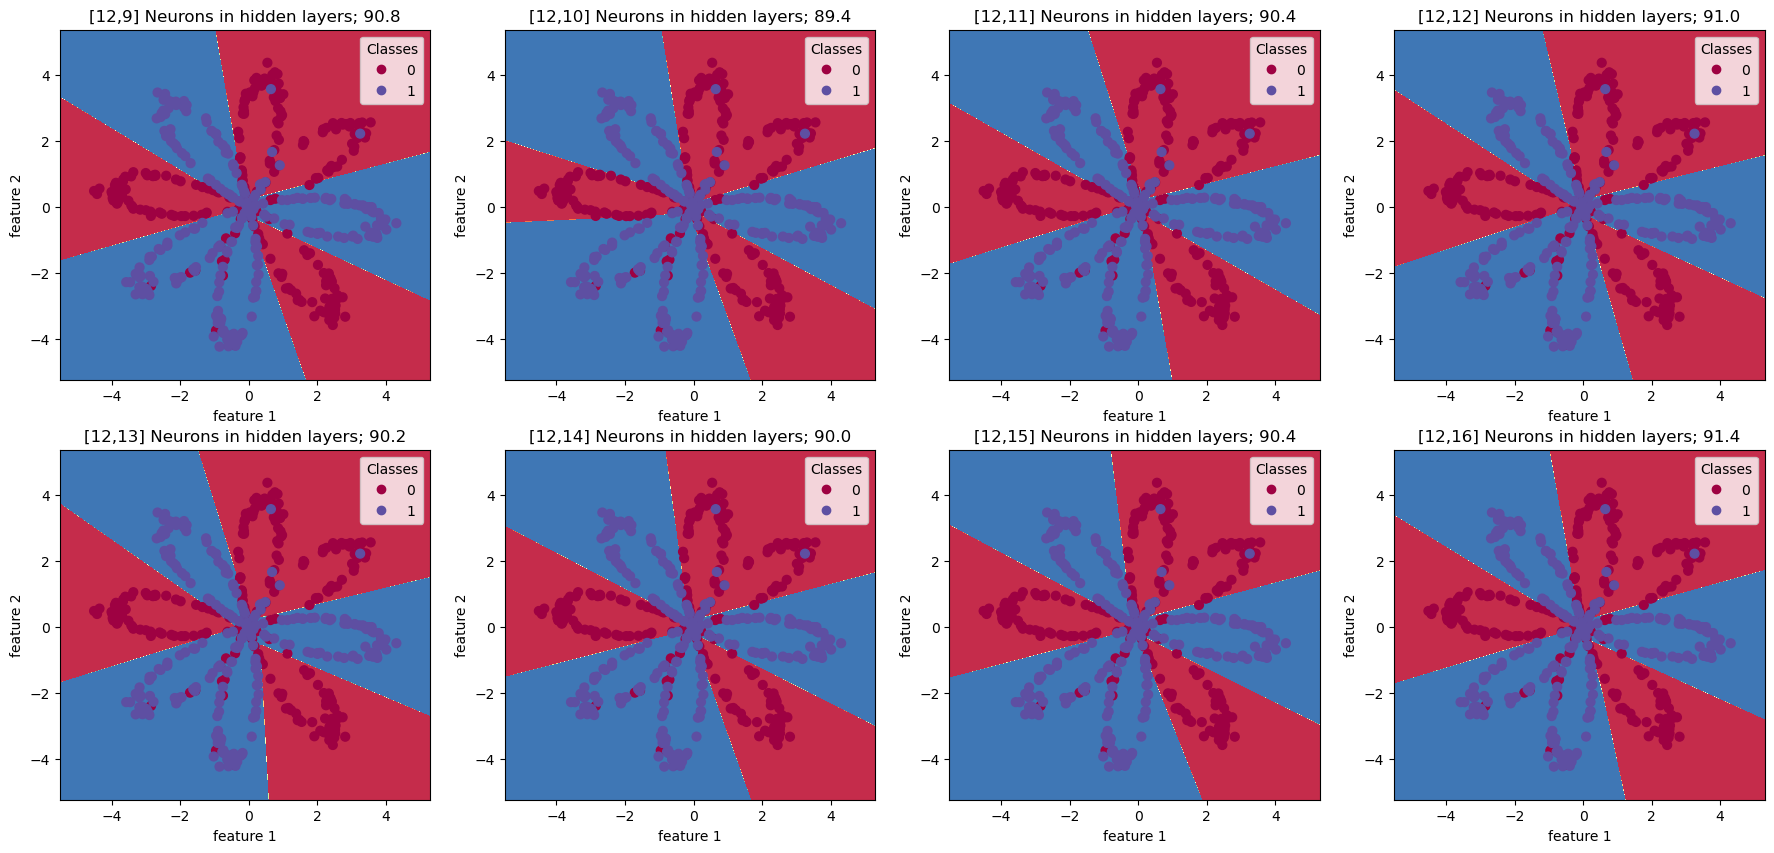

In [10]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[0],7, 1]
plt.rcParams['figure.figsize'] = (22.0, 10.0) # width, height
for i in range(1,9):
        layers_dims=[X.shape[0],12,i+8, 1]
        plt.subplot(2, 4, i)
        parameters, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
        Y_pred_out=predict(X, Y, parameters,activation_L_1,activation_L, print_accuracy=False)
        plot_decision_boundary(predict, parameters, X, Y)
        plt.title(f"[12,{i+8}] Neurons in hidden layers; {np.round(np.mean(Y_pred_out == Y)*100, 3)}")

### 4 Layers (or 3 hidden layers) Neural Network with 1 neuron in output layer

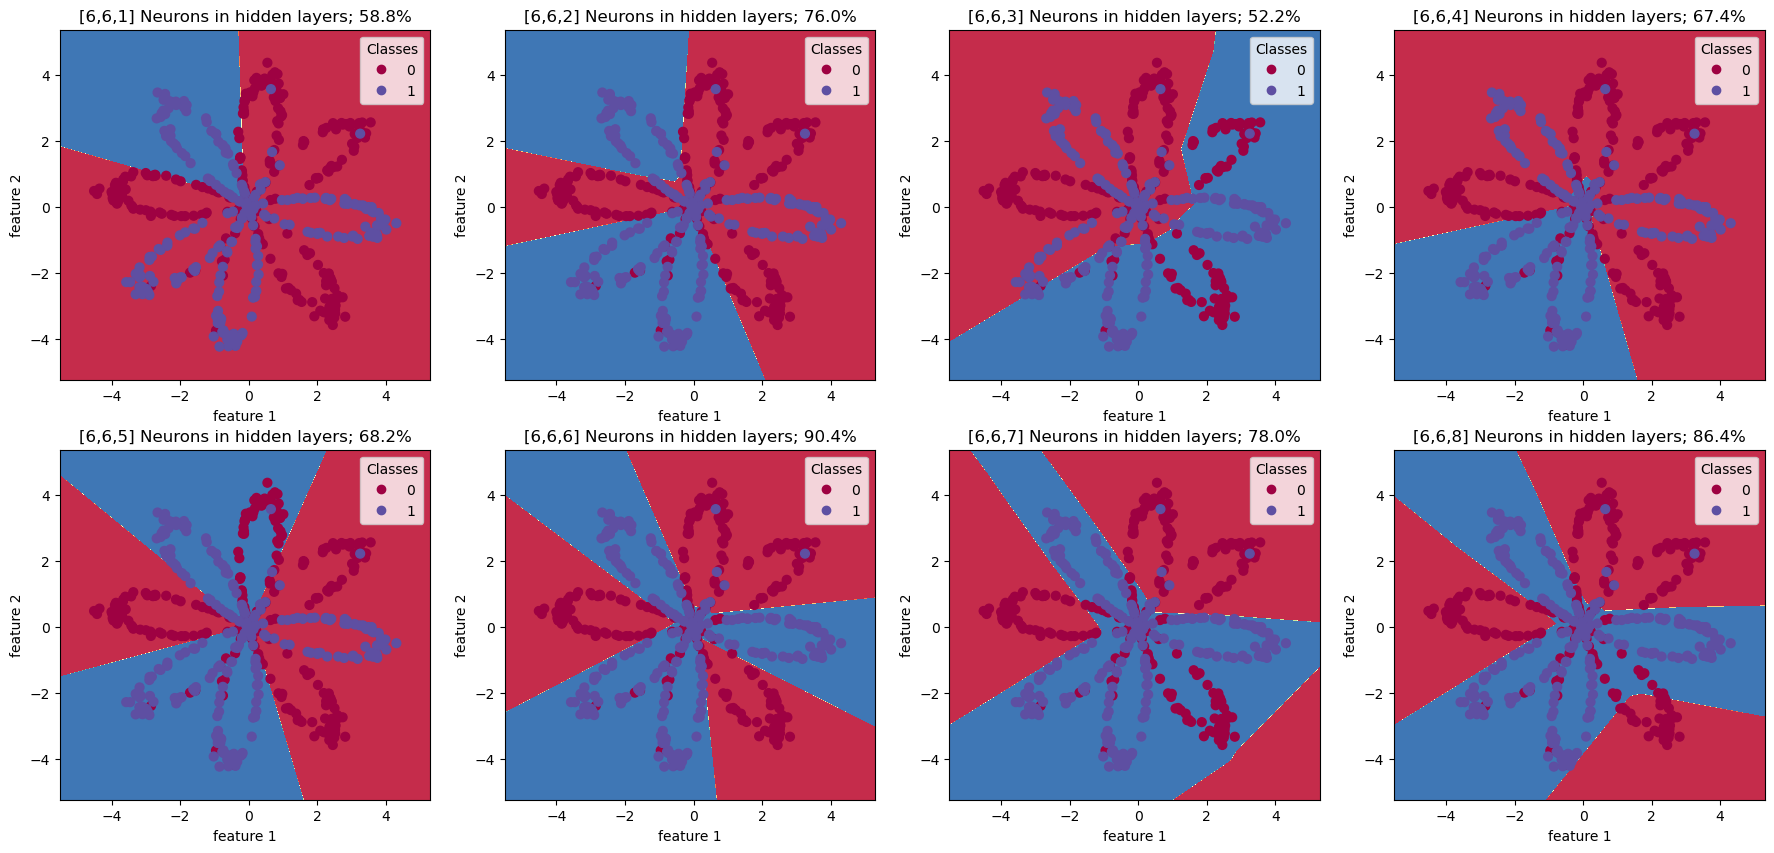

In [11]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[0],6,6,6, 1]
plt.rcParams['figure.figsize'] = (22.0, 10.0) # width, height
for i in range(1,9):
        layers_dims=[X.shape[0],6,6,i, 1]
        plt.subplot(2, 4, i)
        parameters, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
        Y_pred_out=predict(X, Y, parameters,activation_L_1,activation_L, print_accuracy=False)
        plot_decision_boundary(predict, parameters, X, Y)
        plt.title(f"[6,6,{i}] Neurons in hidden layers; {np.round(np.mean(Y_pred_out == Y)*100, 3)}%")

### Conclusion

3 layer neural networks in general give best results and adding more layers is increasing accuracy by much but probably overfitting.

Text(0.5, 1.0, '[12,12] Neurons in hidden layer;  Accuracy : 91.0 %')

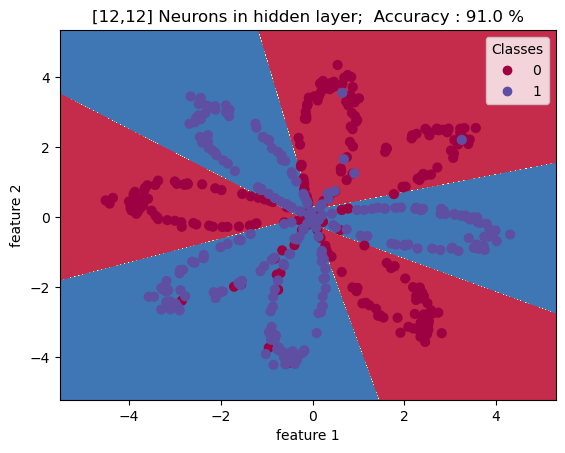

In [12]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
learning_rate = 0.01; layers_dims=[X.shape[0], 12, 12, 1]
parameters, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
Y_pred_out=predict(X, Y, parameters,activation_L_1,activation_L, print_accuracy=False)
plot_decision_boundary(predict, parameters, X, Y)
plt.title(f"[12,12] Neurons in hidden layer;  Accuracy : {np.round(np.mean(Y_pred_out == Y)*100, 3)} %")